In [407]:
import pandas as pd
import numpy as np
import datetime

In [1055]:
from charts import plot_lines

%matplotlib inline

In [511]:
def apple_filter_region(df, region):
    df_region = df[df.region == region].T
    df_region.columns = df_region.loc['transportation_type', :]
    df_region = df_region[~df_region.index.isin(['geo_type', 'region', 'transportation_type'])]
    
    df_region['date'] = pd.to_datetime(df_region.index)
    df_region.set_index('date', inplace=True)
    df_region = df_region.astype('float')
    
    return df_region

In [1040]:
date_apple = '2020-04-24'
date_now = datetime.datetime.strftime(datetime.datetime.utcnow(), "%Y-%m-%d")

dfapple = pd.read_csv(f"data/AppleMobilty/applemobilitytrends-{date_apple}.csv")

dfcovid_conf = pd.read_csv("data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
dfcovid_dead = pd.read_csv("data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

df_germany = pd.read_csv("data/RKI-reports.csv")

### Add index to RKI data

In [1041]:
df_germany['date'] = df_germany['date'].astype('datetime64[ns]')
df_germany = df_germany.sort_values('date', ascending=True)
df_germany.set_index('date', inplace=True)

### Transpose Confirmed Cases

In [1053]:
dfcovid_conf_t = dfcovid_conf.T
dfcovid_conf_t.columns = dfcovid_conf_t.loc['Country/Region', :] + "_" + str(dfcovid_conf_t.loc['Province/State', :])

dfcovid_conf_t.drop(['Country/Region'], axis=0, inplace=True)

df_country_coords = dfcovid_conf_t.loc[['Lat', 'Long'], :]

dfcovid_conf_t.drop(['Lat', 'Long', 'Province/State'], axis=0, inplace=True)
dfcovid_conf_t['dates'] = dfcovid_conf_t.index
dfcovid_conf_t['dates'] = dfcovid_conf_t['dates'].astype('datetime64[ns]')
dfcovid_conf_t = dfcovid_conf_t.sort_values('dates', ascending=True)
dfcovid_conf_t.set_index('dates', inplace=True)

### Transpose Dead Cases

In [1054]:
dfcovid_dead_t = dfcovid_dead.T
dfcovid_dead_t.columns = dfcovid_dead_t.loc['Country/Region', :] + "_" + str(dfcovid_dead_t.loc['Province/State', :])
dfcovid_dead_t.drop(['Country/Region'], axis=0, inplace=True)


dfcovid_dead_t.drop(['Lat', 'Long', 'Province/State'], axis=0, inplace=True)
dfcovid_dead_t['dates'] = dfcovid_dead_t.index
dfcovid_dead_t['dates'] = dfcovid_dead_t['dates'].astype('datetime64[ns]')
dfcovid_dead_t = dfcovid_dead_t.sort_values('dates', ascending=True)
dfcovid_dead_t.set_index('dates', inplace=True)

In [1065]:
import inspect
source_DF = inspect.getsource(add_weekday_weekend)
print(source_DF)


def add_weekday_weekend(df):
    df['dow'] = df.index.weekday
    df['weekend'] = df.index.weekday.isin([5,6])
    return df



### Transpose Mobility and Filter Region

In [1044]:
dfapple_region = apple_filter_region(dfapple, "Hamburg").copy()

### Check max dates in index

In [1045]:
print("Mobility max date:", max(dfapple_region.index))
print("Covi world max date", max(dfcovid_conf_t.index))
print("Covi world max date", max(dfcovid_dead_t.index))
print("RKI max date", max(df_germany.index))

Mobility max date: 2020-04-24 00:00:00
Covi world max date 2020-04-25 00:00:00
Covi world max date 2020-04-25 00:00:00
RKI max date 2020-04-25 00:00:00


### Add weekend Column

# Apple Mobility DF

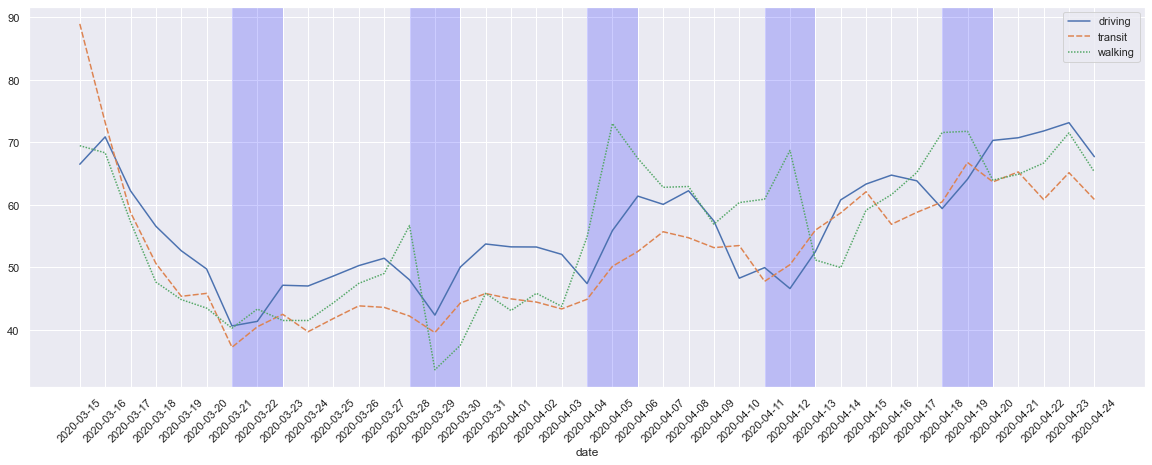

In [1046]:
plot_lines()

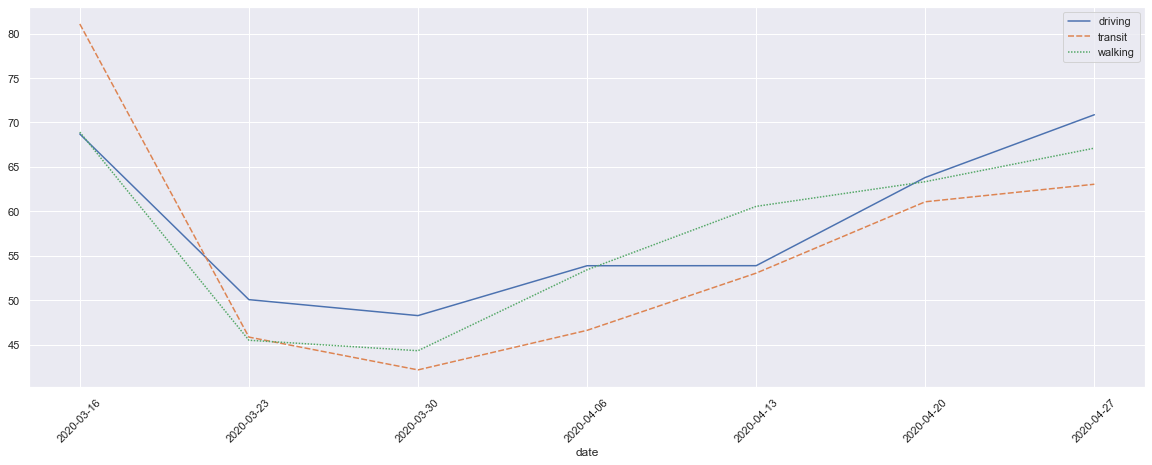

In [1047]:
df = dfapple_region[dfapple_region.index >= '2020-03-15']
df = df.resample('W-MON').mean()

plt.figure(figsize=(20, 7))

ax = sns.lineplot(data=df)

ax.set(xticks=df.index.values)
plt.xticks(rotation=45)

years_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(years_fmt)

## Create lagged and % variables

In [1048]:
dfapple_region.loc[:,'transit_avg3'] = np.round(dfapple_region.loc[:,'transit'].rolling(3, win_type='triang').mean(),0)
dfapple_region.loc[:,'walking_avg3'] = np.round(dfapple_region.loc[:,'walking'].rolling(3, win_type='triang').mean(),0)
dfapple_region.loc[:,'driving_avg3'] = np.round(dfapple_region.loc[:,'driving'].rolling(3, win_type='triang').mean(),0)

dfapple_region = add_lag(dfapple_region, 'transit', 1)
dfapple_region = add_lag(dfapple_region, 'walking', 1)
dfapple_region = add_lag(dfapple_region, 'driving', 1)

dfapple_region = add_lag(dfapple_region, 'transit', 6)
dfapple_region = add_lag(dfapple_region, 'walking', 6)
dfapple_region = add_lag(dfapple_region, 'driving', 6)

dfapple_region['change_%_transit_l6'] = dfapple_region['transit_l6'] / dfapple_region['transit_l6'].shift(1)
dfapple_region['change_%_walking_l6'] = dfapple_region['walking_l6'] / dfapple_region['walking_l6'].shift(1)
dfapple_region['change_%_driving_l6'] = dfapple_region['driving_l6'] / dfapple_region['driving_l6'].shift(1)


# Robert Koch Institute DF

## Filter region (Hamburg)

In [1049]:
df_hamburg = df_germany.loc[df_germany.land == 'Hamburg', :].copy()
df_hamburg.drop('data', axis=1, inplace=True)

## Create lagged and % variables

In [1050]:
def add_variables_confirmed(df):
    # df.loc[:,'confirmed_l1'] = df.loc[:,'confirmed'].shift(1)
    df = add_lag(df, 'confirmed', 1)
    df.loc[:,'confirmed_avg3'] = np.round(df.loc[:,'confirmed'].rolling(3, win_type='triang').mean(),0)
    df.loc[:,'confirmed_avg3_l1'] = df.loc[:,'confirmed_avg3'].shift(1)

    df['change_conf'] = df['confirmed'] - df['confirmed_l1']
    df.loc[:,'change_conf_avg3'] = np.round(df.loc[:,'change_conf'].rolling(3, win_type='triang').mean(),0)
    
    df = add_lag(df, 'change_conf', 1)
    df = add_lag(df, 'change_conf_avg3', 1)
    
    df['change_%_conf'] = df['change_conf'] / df['confirmed_l1']
    df['change_%_conf_avg3'] = df['change_conf_avg3'] / df['confirmed_avg3_l1']
    
    df['change_incr_%_conf'] = 1 - df['change_conf'] / df['change_conf_l1']
    df['change_incr_%_conf_avg3'] = 1 - df['change_conf_avg3'] / df['change_conf_avg3_l1']
    
    return df
    
def add_variables_dead(df):
    
    # df.loc[:,'dead_l1'] = df.loc[:,'dead'].shift(1)
    df = add_lag(df, 'dead', 1)
    df.loc[:,'dead_avg3'] = np.round(df.loc[:,'dead'].rolling(3, win_type='triang').mean(),0)
    df.loc[:,'dead_avg3_l1'] = df.loc[:,'dead_avg3'].shift(1)

    df['change_dead'] = df['dead'] - df['dead_l1']
    df['change_dead_avg3'] = df['dead_avg3'] - df['dead_avg3_l1']

    df = add_lag(df, 'change_dead', 1)
    df = add_lag(df, 'change_dead_avg3', 1)

    df['change_%_dead'] = df['change_dead'] / df['dead_l1']
    df['change_%_dead_avg3'] = df['change_dead_avg3'] / df['dead_avg3_l1']

    df['change_incr_%_dead'] = 1 - df['change_dead'] / df['change_dead_l1']
    df['change_incr_%_dead_avg3'] = 1 - df['change_dead_avg3'] / df['change_dead_avg3_l1']

    df = df.round(2)
    
    return df

In [1051]:
df_hamburg = add_variables_confirmed(df_hamburg)
df_hamburg = add_variables_dead(df_hamburg)

----

In [735]:
df_hamburg.sort_index(ascending=False).head().T

date,2020-04-24,2020-04-23,2020-04-22,2020-04-21,2020-04-20
land,Hamburg,Hamburg,Hamburg,Hamburg,Hamburg
confirmed,4358,4286,4204,4204,4185
dead,122,113,91,91,91
confirmed_l1,4286,4204,4204,4185,4167
confirmed_avg3,4284,4224,4199,4185,4159
confirmed_avg3_l1,4224,4199,4185,4159,4102
change_conf,72,82,0,19,18
change_conf_avg3,60,25,14,26,57
change_conf_l1,82,0,19,18,49
change_conf_avg3_l1,25,14,26,57,82


## Plot

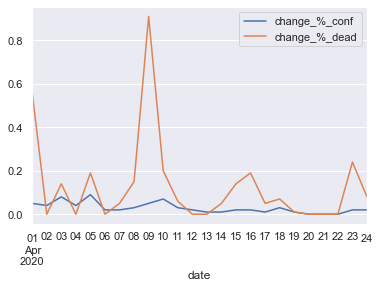

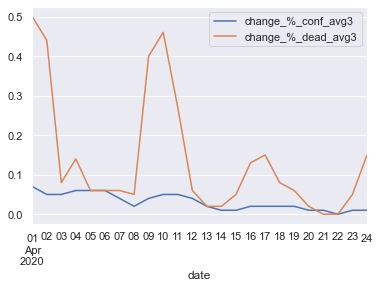

In [681]:
df_hamburg.loc[df_hamburg.index >= '2020-04-01',['change_%_conf', 'change_%_dead']].round(2).plot()
df_hamburg.loc[df_hamburg.index >= '2020-04-01',['change_%_conf_avg3','change_%_dead_avg3']].round(2).plot()

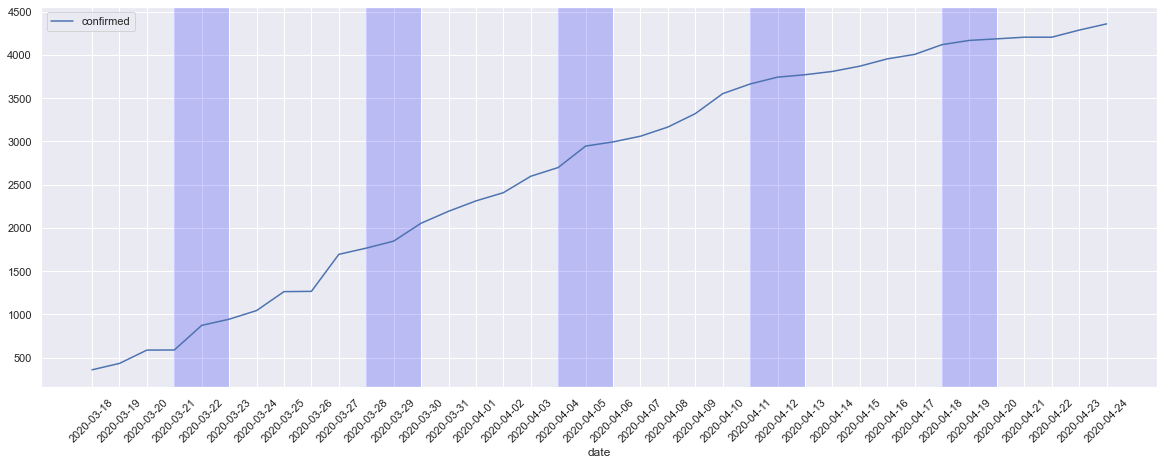

In [682]:
plt.figure(figsize=(20, 7))
df = df_hamburg.loc[df_hamburg.index >= '2020-03-15', ['confirmed']]
ax = sns.lineplot(data=df)

ax.set(xticks=df.index.values)
plt.xticks(rotation=45)

years_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(years_fmt)

highlight_weekends(df, ax)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),
 <a list of 38 Text major ticklabel objects>)

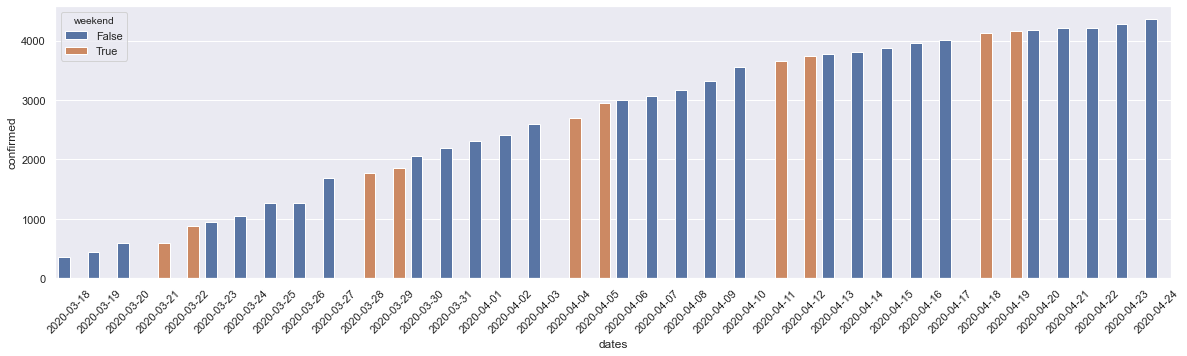

In [707]:
plt.figure(figsize=(20, 5))
df = df_hamburg.loc[df_hamburg.index >= '2020-03-15', ['confirmed']]
df['dates'] = df.index.date
df = add_weekday_weekend(df)

ax = sns.barplot(x='dates', y='confirmed', hue='weekend', data=df)
plt.xticks(rotation=45)

In [736]:
df_russia = dfcovid_conf_t.loc[dfcovid_conf_t.index >= '2020-03-15', ['Russia']]
df_russia.columns = ['confirmed']
df_russia = add_variables_confirmed(df_russia)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]),
 <a list of 41 Text major ticklabel objects>)

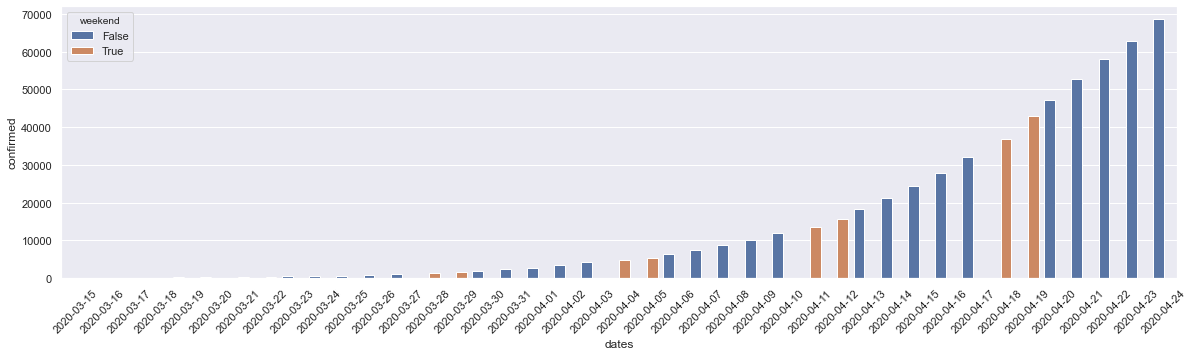

In [737]:
y = 'confirmed'

df = df_russia
df['dates'] = df.index.date
df = add_weekday_weekend(df)

plt.figure(figsize=(20, 5))
ax = sns.barplot(x='dates', y=y, hue='weekend', data=df)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),
 <a list of 38 Text major ticklabel objects>)

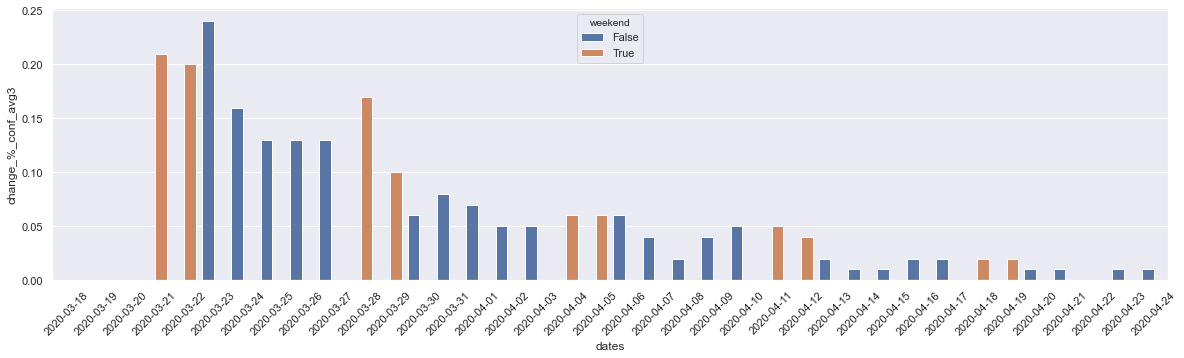

In [711]:
y = 'change_%_conf_avg3'

df = df_hamburg.loc[df_hamburg.index >= '2020-03-15']
df['dates'] = df.index.date
df = add_weekday_weekend(df)

plt.figure(figsize=(20, 5))
ax = sns.barplot(x='dates', y=y, hue='weekend', data=df)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]),
 <a list of 41 Text major ticklabel objects>)

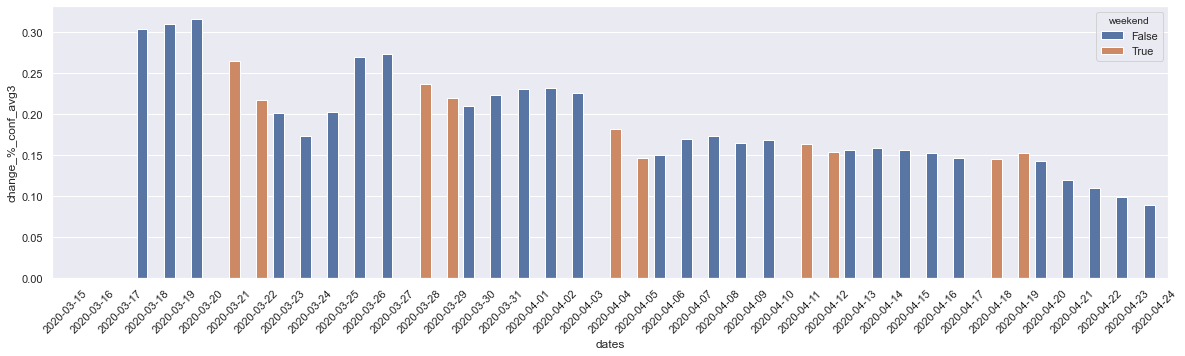

In [738]:
y = 'change_%_conf_avg3'

df = df_russia.loc[df_russia.index >= '2020-03-15']
df['dates'] = df.index.date
df = add_weekday_weekend(df)

plt.figure(figsize=(20, 5))
ax = sns.barplot(x='dates', y=y, hue='weekend', data=df)
plt.xticks(rotation=45)

In [771]:
y = 'doubling_days'

df = df_russia.loc[df_russia.index >= '2020-03-15']
df['dates'] = df.index.date
df = add_weekday_weekend(df)

plt.figure(figsize=(20, 5))
ax = sns.barplot(x='dates', y=y, hue='weekend', data=df)
plt.xticks(rotation=45)

ValueError: Could not interpret input 'doubling_days'

<Figure size 1440x360 with 0 Axes>

## Join RKI and Mobility

In [684]:
df_joined = dfapple_region.join(df_hamburg)

In [685]:
df_joined.loc['2020-03-18':'2020-03-30', ['change_%_conf','change_%_conf_avg3', 'transit', 'walking', 'driving']]

,change_%_conf,change_%_conf_avg3,transit,walking,driving
date,,,,,
2020-03-18,NaN,NaN,50.64,47.66,56.59
2020-03-19,0.21,NaN,45.38,44.86,52.67
2020-03-20,0.36,NaN,45.85,43.49,49.75
2020-03-21,0.00,0.21,37.23,40.28,40.64
2020-03-22,0.49,0.20,40.51,43.34,41.37
2020-03-23,0.08,0.24,42.50,41.51,47.15
2020-03-24,0.11,0.16,39.71,41.51,47.03
2020-03-25,0.21,0.13,41.83,44.35,48.63
2020-03-26,0.00,0.13,43.85,47.45,50.29


In [686]:
dfcovid_conf.loc[dfcovid["Country/Region"] == 'Russia']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20
187,NaN,Russia,60.0,90.0,0,0,0,0,0,0,...,24490,27938,32008,36793,42853,47121,52763,57999,62773,68622
